In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform
)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

classes = trainset.classes


100%|██████████| 170M/170M [00:02<00:00, 69.4MB/s]


In [3]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)   # Input: 3x32x32 → Output: 16x32x32
        self.pool = nn.MaxPool2d(2, 2)                # Output size halves → 16x16x16
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)  # Output: 32x16x16 → 32x8x8 after pooling
        self.fc1 = nn.Linear(32 * 8 * 8, 128)         # Fully connected layer
        self.fc2 = nn.Linear(128, 10)                 # 10 output classes
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 32 * 8 * 8)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [5]:
for epoch in range(10):  # Train for 10 epochs
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()        # Reset gradients
        outputs = model(inputs)      # Forward pass
        loss = loss_fn(outputs, labels)
        loss.backward()              # Backpropagation
        optimizer.step()             # Update weights

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss / len(trainloader):.4f}")

Epoch 1, Loss: 1.4302
Epoch 2, Loss: 1.0937
Epoch 3, Loss: 0.9527
Epoch 4, Loss: 0.8536
Epoch 5, Loss: 0.7720
Epoch 6, Loss: 0.7050
Epoch 7, Loss: 0.6421
Epoch 8, Loss: 0.5868
Epoch 9, Loss: 0.5314
Epoch 10, Loss: 0.4816


In [6]:
correct, total = 0, 0
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on test data: {100 * correct / total:.2f}%")

Accuracy on test data: 69.65%


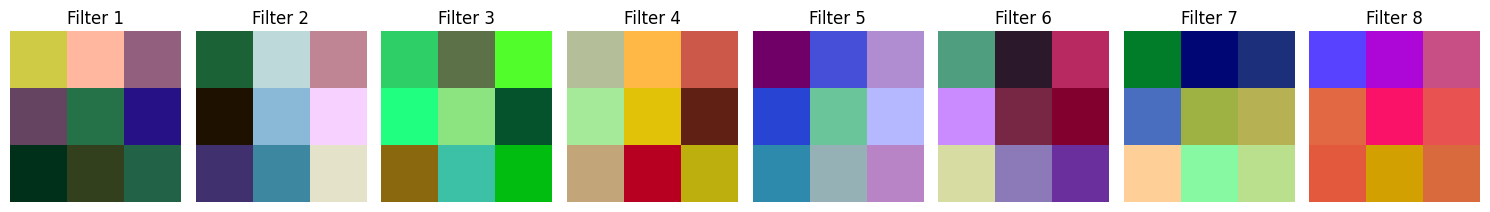

In [7]:
def visualize_filters(layer, n_filters=8):
    filters = layer.weight.data.clone().cpu()
    fig, axs = plt.subplots(1, n_filters, figsize=(15, 4))

    for i in range(n_filters):
        f = filters[i]
        f = (f - f.min()) / (f.max() - f.min())  # Normalize to [0,1] for display
        axs[i].imshow(f.permute(1, 2, 0))       # Rearrange to HxWxC
        axs[i].axis('off')
        axs[i].set_title(f'Filter {i+1}')

    plt.tight_layout()
    plt.show()

visualize_filters(model.conv1)